# EEG-02 Solutions

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

Today's demonstration will introduce epoching and event-related potential analysis using `mne-python`. We will inspect EEG data in response to visual and auditory stimuli. We will start by loading the data from last session.

In [2]:
from mne.io import read_raw_fif

## Load data.
f = os.path.join('..','eeg-data','sub-01_task-audvis_preproc_raw.fif')
raw = read_raw_fif(f, preload=True, verbose=False)

## Section 1: Finding and defining events

In addition to the EEG and peripheral channels, our recording includes trigger channels. Trigger channels mark the onset/offset of events during recording. In our recording in particular, STI 014 is the trigger channel that was used for combining all the events to a single channel. It has several pulses of different amplitude throughout the recording. These pulses correspond to different stimuli presented to the subject during the acquisition. The pulses and their corresponding events are defined in the table below.

| Name   | #  | Contents                                |
|--------|----|-----------------------------------------|
| LA     | 1  | Response to left-ear auditory stimulus  |
| RA     | 2  | Response to right-ear auditory stimulus |
| LV     | 3  | Response to left visual field stimulus  |
| RV     | 4  | Response to right visual field stimulus |
| Smiley | 5  | Response to the smiley face             |
| Button | 32 | Response triggered by the button press  |

These are the events we are going to align the epochs to. To create an event list from raw data, we simply call a function dedicated just for that. Since the event list is simply a numpy array, you can also manually create one. If you create one from an outside source (like a separate file of events), pay special attention in aligning the events correctly with the raw data.

In [3]:
from mne import find_events
from mne.viz import plot_events

## Find events.
events = find_events(raw)
print(events[:5])

320 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


The event list contains three columns. The first column corresponds to sample number. To convert this to seconds, you should divide the sample number by the used sampling frequency. The second column is reserved for the old value of the trigger channel at the time of transition, but is currently not in use. The third column is the trigger id (amplitude of the pulse).

To get a better picture of the task design, we'll plot out the events. First we'll need to construct an *event_id*, which is a Python dictionary matching event labels to event integers.

In [4]:
## Plot the events.
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2, 'Visual/Left': 3, 'Visual/Right': 4,
            'smiley': 5, 'button': 32}

Now we plot.

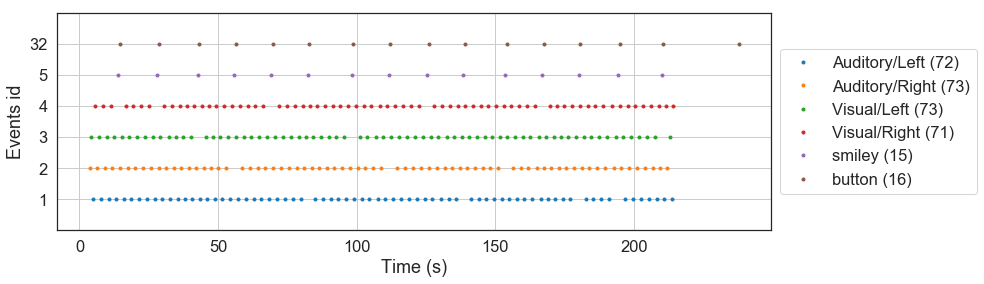

In [5]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(16,4))

## Plot events.
color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728', 5: '#9467bd', 32: '#8c564b'}
plot_events(events, raw.info['sfreq'], raw.first_samp, color=color, event_id=event_id, axes=ax);

## Section 2: Epoching

Epoching describes the process of taking snapshots of the data centered around some event of interest. We will perform epoching using the `mne.Epochs` constructor. To do so, we need to define some parameters for our epoching.

In this tutorial we are only interested in triggers 1, 2, 3 and 4. These triggers correspond to auditory and visual stimuli. The event_id here can be an int, a list of ints or a dict. With dicts it is possible to assign these ids to distinct categories.

In [6]:
## Define events of interest.
event_id = dict(LA=1, RA=2, LV=3, RV=4)

Next we need to define the windows of interest. The values tmin and tmax refer to offsets in relation to the events. Here we make epochs that collect the data from -500 ms before to 500 ms after the event. To get some meaningful results, we also want to baseline the epochs. Baselining computes the mean over the baseline period and adjusts the data accordingly. The epochs constructor uses a baseline period from tmin to 0.0 seconds by default, but it is wise to be explicit. That way you are less likely to end up with surprises along the way. None as the first element of the tuple refers to the start of the time window (-200 ms in this case). See `mne.Epochs` for more information.


In [7]:
## Define epoch lengths.
tmin = -0.2
tmax = 0.5
baseline = (None, -0.1)

Next we define our Rejection parameters for peak-to-peak amplitude.

In [8]:
## Define rejection threshold.
reject = dict(eeg = 100e-6)

Finally we perform epoching, choosing only the EEG channels.

In [9]:
from mne import Epochs, pick_types

## Perform epoching.
picks = pick_types(raw.info, meg=False, eeg=True)
epochs = Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=baseline,
                picks=picks, reject=reject, preload=True, verbose=False)

print(epochs)

<Epochs  |   286 events (all good), -0.199795 - 0.499488 sec, baseline [None, -0.1], ~57.3 MB, data loaded,
 'LA': 72
 'LV': 71
 'RA': 72
 'RV': 71>


Next we remove all bad epochs (i.e. those violating amplitude rejection).

In [10]:
## Crop epochs.
epochs = epochs.crop(tmin=-0.1)

## Drop bad epochs.
epochs.drop_bad()
print(epochs)

<Epochs  |   286 events (all good), -0.0998976 - 0.499488 sec, baseline [None, -0.1], ~49.6 MB, data loaded,
 'LA': 72
 'LV': 71
 'RA': 72
 'RV': 71>


Finally we save the data. Note the naming convenction.

In [11]:
## Save.
fout = os.path.join('..','eeg-data','sub-01_task-audvis-epo.fif')
epochs.save(fout)

## Section 3: ERP Analysis & Visualization

Now that we have defined our epochs, we can inspect the event-related potentials. There are a great many example tutorials on visualizing evoked potentials [here](https://www.martinos.org/mne/stable/auto_tutorials/plot_visualize_evoked.html). We demonstrate a few below.

### Visual Stimuli
First we compute the evoked response for each auditory stimulus condition.

In [12]:
## Average within each condition.
LV_evoked = epochs['LV'].average()
RV_evoked = epochs['RV'].average()

#### Evoked Related Potentials
Next let's plot the ERP for each condition.

Left visual


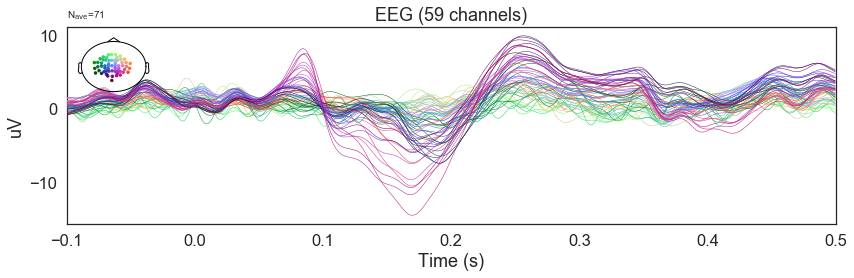

Right visual


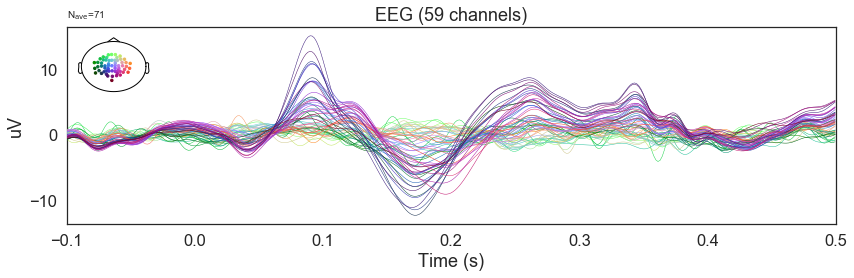

In [13]:
print('Left visual')
fig, ax = plt.subplots(1,1,figsize=(12,4))
fig = LV_evoked.plot(spatial_colors=True, xlim=(-0.1,0.5), axes=ax);

print('Right visual')
fig, ax = plt.subplots(1,1,figsize=(12,4))
fig = RV_evoked.plot(spatial_colors=True, xlim=(-0.1,0.5), axes=ax);

### Compare Evoked Potentials

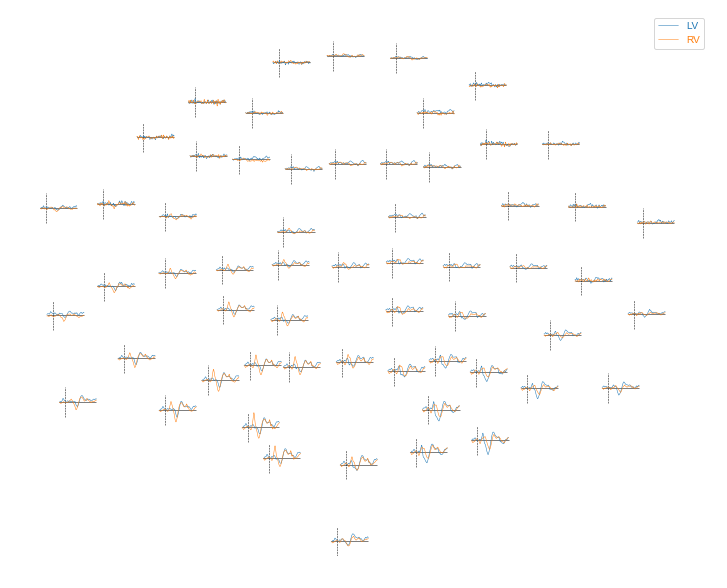

In [14]:
from mne.viz import plot_evoked_topo

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,10))

## Plot.
plot_evoked_topo([LV_evoked, RV_evoked], axes=ax);

#### Topographic Plots
We can also plot the scalp topographic maps for each condition.

Left visual


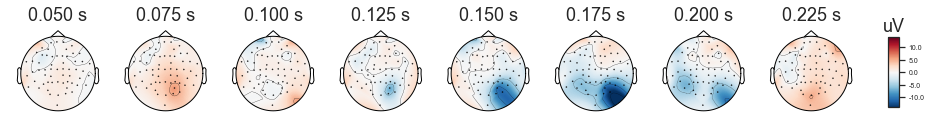

Right visual


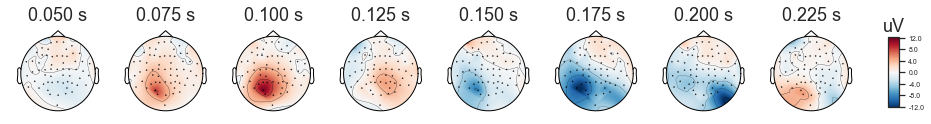

In [15]:
print('Left visual')
LV_evoked.plot_topomap(times=np.arange(0.05,0.25,0.025));
print('Right visual')
RV_evoked.plot_topomap(times=np.arange(0.05,0.25,0.025));

#### Comparing Evoked Potentials

Using the sensor layout from the previous notebook, we can choose a sensor that is clearly picking up a response to the visual stimuli. Here we are observing strong laterality, so we visual two sensors: **EEG 056** and **EEG 057**. We will clearly see that that right- and left-presented stimuli are more strongly represented in the contralateral hemispheres.

**EEG 056**

<ipython-input-16-8d52efc13ece>:11: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  seed=47404, verbose=False)


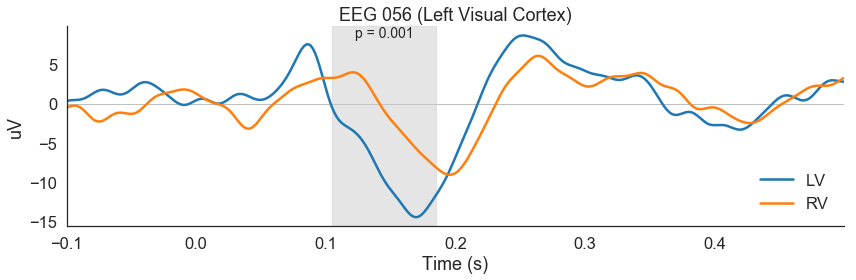

In [16]:
from mne.stats import permutation_cluster_test

## Extract data.
eeg_056 = epochs.copy().pick_channels(['EEG 056'])
data = [eeg_056['LV'].get_data().squeeze(), eeg_056['RV'].get_data().squeeze()]
evokeds = np.mean(data, axis=1) * 1e6

## Using F-statistic as default.
## F-stat = abs(t-stat ** 2)
F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(data, n_permutations=1024, 
                                                           seed=47404, verbose=False)

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(epochs.times, evokeds[0], lw=2.5, label='LV')            # Cond: LV
ax.plot(epochs.times, evokeds[1], lw=2.5, label='RV')            # Cond: RV
# ax.plot(epochs.times, F_obs, lw=2, color='0.2', label='F-vals')  # F-stats
ymin, ymax = ax.get_ylim()

## Plot clusters.
for cluster, pval in zip(clusters, cluster_pv): 
    if pval < 0.05:
        center = epochs.times[cluster].mean()
        ax.fill_between(epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
        ax.annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)
    
## Add details.
ax.hlines(0, epochs.tmin, epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
ax.set(xlim=(epochs.tmin, epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
       ylabel='uV', title='EEG 056 (Left Visual Cortex)')
ax.legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

**EEG 057**

<ipython-input-17-f26e8d8155f4>:11: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  seed=47404, verbose=False)


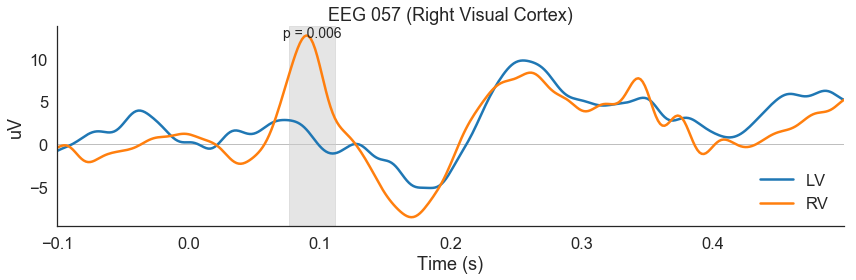

In [17]:
from mne.stats import permutation_cluster_test

## Extract data.
eeg_057 = epochs.copy().pick_channels(['EEG 057'])
data = [eeg_057['LV'].get_data().squeeze(), eeg_057['RV'].get_data().squeeze()]
evokeds = np.mean(data, axis=1) * 1e6

## Using F-statistic as default.
## F-stat = abs(t-stat ** 2)
F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(data, n_permutations=1024, 
                                                           seed=47404, verbose=False)

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(epochs.times, evokeds[0], lw=2.5, label='LV')            # Cond: LV
ax.plot(epochs.times, evokeds[1], lw=2.5, label='RV')            # Cond: RV
# ax.plot(epochs.times, F_obs, lw=2, color='0.2', label='F-vals')  # F-stats
ymin, ymax = ax.get_ylim()

## Plot clusters.
for cluster, pval in zip(clusters, cluster_pv): 
    if pval < 0.05:
        center = epochs.times[cluster].mean()
        ax.fill_between(epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
        ax.annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)
    
## Add details.
ax.hlines(0, epochs.tmin, epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
ax.set(xlim=(epochs.tmin, epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
       ylabel='uV', title='EEG 057 (Right Visual Cortex)')
ax.legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

### Difference Waves

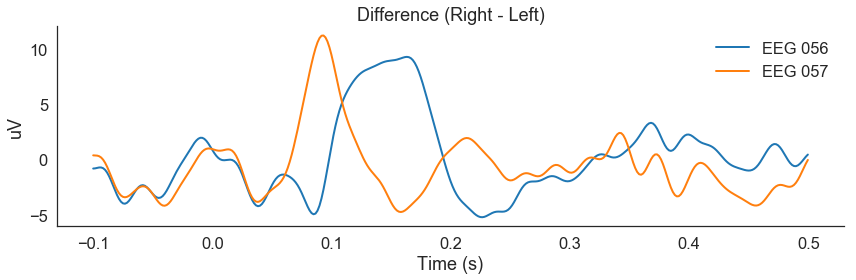

In [18]:
from mne import combine_evoked

## Compute difference wave.
DV_evoked = combine_evoked([LV_evoked, RV_evoked], [-1,1])

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot difference waves.
for ch in ['EEG 056', 'EEG 057']:
    ax.plot(DV_evoked.times, DV_evoked.data[DV_evoked.ch_names.index(ch)] * 1e6, lw=2, label=ch)
    
## Add info.
ax.set(xlabel='Time (s)', ylabel='uV', title='Difference (Right - Left)')
ax.legend(loc=1, frameon=False)
sns.despine()
plt.tight_layout()